In [10]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Restrict to GPUs 0 
torch.cuda.set_device(0)  # Explicitly select GPU 0

print(f"CUDA Available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")
print(f"Current Device: {torch.cuda.current_device()}")
print(f"Device Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")



CUDA Available: True
Number of GPUs: 1
Current Device: 0
Device Name: NVIDIA H100 80GB HBM3


# Generate diode_meta.json file

In [ ]:
import os
import json

# Define dataset root (ensure you're inside /home/exp1/zihan2/DIODE_dataset)
dataset_root = os.getcwd()

# Define dataset structure
splits = ["train", "val"]
scene_types = ["indoors"]  # Modify if you have "outdoor"

# Initialize meta dictionary
diode_meta = {split: {scene: {"images": [], "depth_maps": []} for scene in scene_types} for split in splits}
diode_meta["train_normals"] = {scene: [] for scene in scene_types}
diode_meta["val_normals"] = {scene: [] for scene in scene_types}

# Traverse dataset for train/val images and depth maps
for split in ["train", "val"]:
    for scene in scene_types:
        scene_path = os.path.join(dataset_root, split, scene)
        if not os.path.exists(scene_path):
            print(f"Skipping missing directory: {scene_path}")
            continue

        # Iterate over scene folders (scene_00000, scene_00001, ...)
        for scene_folder in sorted(os.listdir(scene_path)):
            scene_dir = os.path.join(scene_path, scene_folder)
            if os.path.isdir(scene_dir):
                # Iterate over scan folders (scan_0000, scan_0001, ...)
                for scan_folder in sorted(os.listdir(scene_dir)):
                    scan_dir = os.path.join(scene_dir, scan_folder)
                    if os.path.isdir(scan_dir):
                        # Collect all image files in the scan folder
                        images = sorted([f for f in os.listdir(scan_dir) if f.endswith(('.png', '.jpg'))])
                        depth_maps = sorted([f for f in os.listdir(scan_dir) if f.endswith('_depth.npy')])

                        # Store relative paths
                        for img in images:
                            diode_meta[split][scene]["images"].append(f"{scene_folder}/{scan_folder}/{img}")
                        for depth in depth_maps:
                            diode_meta[split][scene]["depth_maps"].append(f"{scene_folder}/{scan_folder}/{depth}")

# Traverse separate folder for training normal maps (train_normals)
train_normals_path = os.path.join(dataset_root, "train_normals", "indoors")
if os.path.exists(train_normals_path):
    for scene_folder in sorted(os.listdir(train_normals_path)):
        scene_dir = os.path.join(train_normals_path, scene_folder)
        if os.path.isdir(scene_dir):
            for scan_folder in sorted(os.listdir(scene_dir)):
                scan_dir = os.path.join(scene_dir, scan_folder)
                if os.path.isdir(scan_dir):
                    normal_maps = sorted([f for f in os.listdir(scan_dir) if f.endswith('_normal.npy')])
                    for normal in normal_maps:
                        diode_meta["train_normals"]["indoors"].append(f"{scene_folder}/{scan_folder}/{normal}")

val_normals_path = os.path.join(dataset_root, "val_normals", "indoors")
if os.path.exists(val_normals_path):
    for scene_folder in sorted(os.listdir(val_normals_path)):
        scene_dir = os.path.join(val_normals_path, scene_folder)
        if os.path.isdir(scene_dir):
            for scan_folder in sorted(os.listdir(scene_dir)):
                scan_dir = os.path.join(scene_dir, scan_folder)
                if os.path.isdir(scan_dir):
                    normal_maps = sorted([f for f in os.listdir(scan_dir) if f.endswith('_normal.npy')])
                    for normal in normal_maps:
                        diode_meta["val_normals"]["indoors"].append(f"{scene_folder}/{scan_folder}/{normal}")

# Save meta file
meta_file = os.path.join(dataset_root, "diode_meta3.json")
with open(meta_file, "w") as f:
    json.dump(diode_meta, f, indent=4)

print(f"Generated {meta_file}")


✅ Generated /home/exp1/zihan2/DIODE_dataset/diode_meta3.json


# Generate diode_meta.json file with psuedo ground truths for albedo/shading training

In [ ]:
# import os
# import json

# dataset_root = os.getcwd()
# splits = ["train", "val"]
# scene_types = ["indoors"]

# # Initialize meta structure
# diode_meta = {
#     split: {scene: {"images": [], "depth_maps": []} for scene in scene_types}
#     for split in splits
# }
# diode_meta.update({
#     "train_normals": {scene: [] for scene in scene_types},
#     "val_normals": {scene: [] for scene in scene_types},
#     "train_albedo": {scene: [] for scene in scene_types},
#     "val_albedo": {scene: [] for scene in scene_types},
#     "train_shading": {scene: [] for scene in scene_types},
#     "val_shading": {scene: [] for scene in scene_types},
# })

# def append_if_exists(path, key, scene, filename):
#     if os.path.exists(path):
#         diode_meta[key][scene].append(filename)

# # Traverse image + depth
# for split in splits:
#     for scene in scene_types:
#         scene_path = os.path.join(dataset_root, split, scene)
#         if not os.path.exists(scene_path):
#             continue

#         for scene_folder in sorted(os.listdir(scene_path)):
#             scene_dir = os.path.join(scene_path, scene_folder)
#             if not os.path.isdir(scene_dir):
#                 continue

#             for scan_folder in sorted(os.listdir(scene_dir)):
#                 scan_dir = os.path.join(scene_dir, scan_folder)
#                 if not os.path.isdir(scan_dir):
#                     continue

#                 # Images
#                 for file in sorted(os.listdir(scan_dir)):
#                     if file.endswith((".png", ".jpg")):
#                         rel_path = f"{scene_folder}/{scan_folder}/{file}"
#                         diode_meta[split][scene]["images"].append(rel_path)
#                     elif file.endswith("_depth.npy"):
#                         rel_path = f"{scene_folder}/{scan_folder}/{file}"
#                         diode_meta[split][scene]["depth_maps"].append(rel_path)

# # Handle normals, albedo, shading maps
# intrinsics = ["normals", "albedo", "shading"]
# for intrinsic in intrinsics:
#     for split in splits:
#         key = f"{split}_{intrinsic}"
#         intrinsic_dir = os.path.join(dataset_root, key, "indoors")
#         if not os.path.exists(intrinsic_dir):
#             continue

#         for scene_folder in sorted(os.listdir(intrinsic_dir)):
#             scene_dir = os.path.join(intrinsic_dir, scene_folder)
#             if not os.path.isdir(scene_dir):
#                 continue

#             for scan_folder in sorted(os.listdir(scene_dir)):
#                 scan_dir = os.path.join(scene_dir, scan_folder)
#                 if not os.path.isdir(scan_dir):
#                     continue

#                 for file in sorted(os.listdir(scan_dir)):
#                     if file.endswith(f"_{intrinsic[:-1]}.npy"):
#                         rel_path = f"{scene_folder}/{scan_folder}/{file}"
#                         diode_meta[key]["indoors"].append(rel_path)

# # Save updated JSON
# meta_path = os.path.join(dataset_root, "diode_meta3.json")
# with open(meta_path, "w") as f:
#     json.dump(diode_meta, f, indent=4)

# print("f Successfully generated {meta_path}")


# Show image for specific image "normal" and calculate MSE and then for "depth"

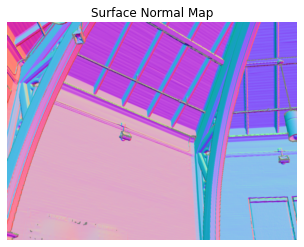

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Load the normal .npy file
npy_path = "/home/exp1/zihan2/DIODE_dataset/val_normals/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_normal.npy"
normal_map = np.load(npy_path)  # e.g. shape [3, H, W]

# Make sure it's shape (H, W, 3)
if normal_map.shape[0] == 3:
    normal_map_vis = np.transpose(normal_map, (1, 2, 0))  # (3, H, W) → (H, W, 3)
elif normal_map.shape[-1] == 3:
    normal_map_vis = normal_map  # already (H, W, 3)
elif normal_map.shape[1] == 3:
    normal_map_vis = np.transpose(normal_map, (0, 2, 1))  # Fix (H, 3, W) → (H, W, 3)
else:
    raise ValueError(f"Unexpected shape: {normal_map.shape}")

# Normalize from [-1, 1] → [0, 1]
normal_map_vis = (normal_map_vis + 1) / 2.0
normal_map_vis = np.clip(normal_map_vis, 0, 1)

# Display
plt.imshow(normal_map_vis)
plt.title("Surface Normal Map")
plt.axis("off")
plt.show()


In [11]:
import numpy as np
from PIL import Image
import torch
import torch.nn.functional as F

# === Paths ===
pred_path = "/home/exp1/zihan2/DIODE_dataset/val_normals_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_040.png"
gt_path = "/home/exp1/zihan2/DIODE_dataset/val_normals/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_normal.npy"

# === Load predicted image ===
pred_img = Image.open(pred_path).convert("RGB")
pred_np = np.array(pred_img).astype(np.float32) / 255.0  # [H, W, 3]
print(f"Raw pred_np shape: {pred_np.shape}")

if pred_np.shape[-1] == 3:
    pred_tensor = torch.tensor(pred_np).permute(2, 0, 1)  # → [3, H, W]
else:
    raise ValueError(f"Unexpected predicted image shape: {pred_np.shape}")

# === Load GT normal map ===
gt_np = np.load(gt_path)  # Expected shape: [H, W, 3] or [3, H, W]
print(f"Raw gt_np shape: {gt_np.shape}")

if gt_np.shape[0] == 3:
    gt_tensor = torch.tensor(gt_np, dtype=torch.float32)
elif gt_np.shape[-1] == 3:
    gt_tensor = torch.tensor(gt_np, dtype=torch.float32).permute(2, 0, 1)
else:
    raise ValueError(f"Unexpected GT shape: {gt_np.shape}")

# === Resize GT if needed ===
if gt_tensor.shape[-2:] != pred_tensor.shape[-2:]:
    gt_tensor = F.interpolate(gt_tensor.unsqueeze(0), size=pred_tensor.shape[-2:], mode="bilinear", align_corners=False).squeeze(0)
    print(f"Resized GT to: {gt_tensor.shape}")

# === Normalize to [-1, 1] and unit vectors ===
pred_tensor = (pred_tensor * 2) - 1
pred_tensor = F.normalize(pred_tensor, dim=0)
gt_tensor = F.normalize(gt_tensor, dim=0)

# === Compute Angular Error ===
cos_sim = F.cosine_similarity(pred_tensor, gt_tensor, dim=0).clamp(-1, 1)
angles = torch.acos(cos_sim) * (180.0 / np.pi)  # Convert radians to degrees

mean_angular_error = angles.mean().item()
median_angular_error = angles.median().item()
mean_l1_error = torch.abs(pred_tensor - gt_tensor).mean().item()

print(f"Mean Angular Error: {mean_angular_error:.4f}°")
print(f"Median Angular Error: {median_angular_error:.4f}°")
print(f"Mean L1 Error: {mean_l1_error*100:.6f}")


Raw pred_np shape: (768, 1024, 3)
Raw gt_np shape: (768, 1024, 3)
Mean Angular Error: 87.2399°
Median Angular Error: 91.8010°
Mean L1 Error: 69.294453


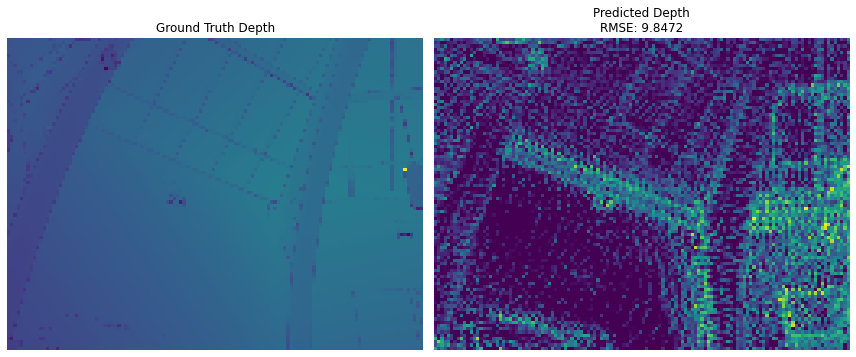

Depth validation completed.
RMSE: 9.847204


In [15]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F

# === Paths ===
pred_path = "/home/exp1/zihan2/DIODE_dataset/val_depths_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_040.npy"
gt_path   = "/home/exp1/zihan2/DIODE_dataset/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_depth.npy"

# === Load depth maps ===
pred = torch.tensor(np.load(pred_path), dtype=torch.float32)
gt   = torch.tensor(np.load(gt_path), dtype=torch.float32)

# === Remove extra channel dimension if exists ===
if gt.ndim == 3 and gt.shape[-1] == 1:
    gt = gt.squeeze(-1)

# === Resize ground truth to match predicted shape if needed ===
if pred.shape != gt.shape:
    gt = F.interpolate(gt.unsqueeze(0).unsqueeze(0), size=pred.shape, mode='bilinear', align_corners=False).squeeze()

# === Clamp values to avoid division by zero ===
eps = 1e-6
pred = torch.clamp(pred, min=eps)
gt = torch.clamp(gt, min=eps)

# === Compute metrics ===
mse_scores = []
rmse_scores = []


mse = torch.mean((pred - gt) ** 2).item()
rmse = torch.sqrt(torch.mean((pred - gt) ** 2)).item()

mse_scores.append(mse)
rmse_scores.append(rmse)

# === Normalize for visualization ===
def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

pred_norm = normalize(pred)
gt_norm = normalize(gt)

# === Visualize ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(gt_norm.cpu().numpy(), cmap="viridis")
plt.title("Ground Truth Depth")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(pred_norm.cpu().numpy(), cmap="viridis")
plt.title(f"Predicted Depth\nRMSE: {rmse:.4f}")
plt.axis("off")

plt.tight_layout()
plt.show()

# === Print results ===
mean_mse = np.mean(mse_scores)
mean_rmse = np.mean(rmse_scores)

print("Depth validation completed.")
print(f"RMSE: {mean_rmse:.6f}")


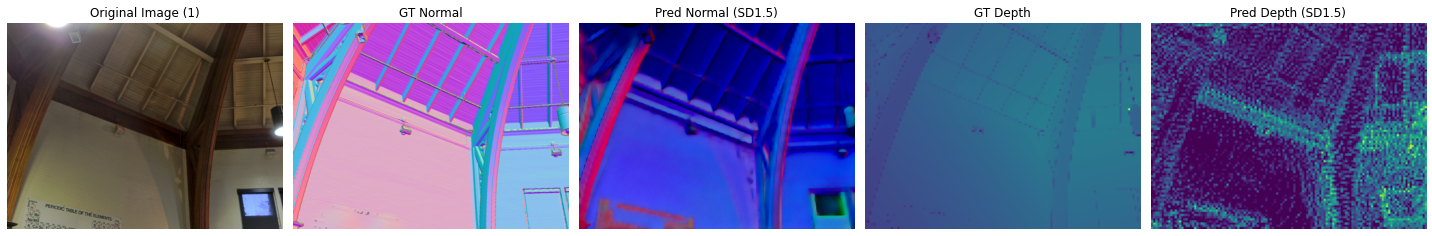


==== Evaluation Metrics (1) ====
Mean Angular Error: 87.2399°
Median Angular Error: 91.8010°
Mean L1 Error: 69.294453
Depth RMSE: 9.847204


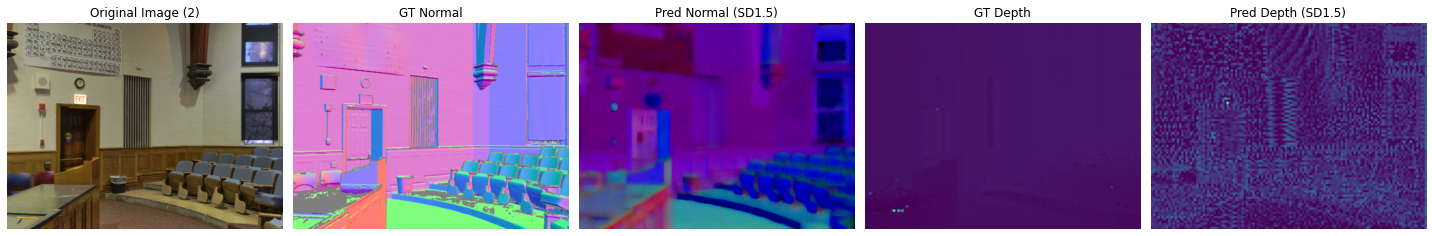


==== Evaluation Metrics (2) ====
Mean Angular Error: 89.7742°
Median Angular Error: 90.9038°
Mean L1 Error: 73.849666
Depth RMSE: 8.548422


In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image

def normalize(x):
    return (x - x.min()) / (x.max() - x.min() + 1e-8)

def evaluate_and_plot(
    img_path, pred_normal_path, gt_normal_path, pred_depth_path, gt_depth_path, title_suffix=""
):
    # === Load original image ===
    orig_img = np.array(Image.open(img_path))

    # === Load predicted normal map ===
    pred_normal_img = Image.open(pred_normal_path).convert("RGB")
    pred_normal_np = np.array(pred_normal_img).astype(np.float32) / 255.0

    # === Load ground truth normal map ===
    gt_normal = np.load(gt_normal_path)
    if gt_normal.shape[0] == 3:
        gt_normal_vis = np.transpose(gt_normal, (1, 2, 0))
        gt_normal_tensor = torch.tensor(gt_normal, dtype=torch.float32)
    elif gt_normal.shape[-1] == 3:
        gt_normal_vis = gt_normal
        gt_normal_tensor = torch.tensor(gt_normal, dtype=torch.float32).permute(2, 0, 1)
    elif gt_normal.shape[1] == 3:
        gt_normal_vis = np.transpose(gt_normal, (0, 2, 1))
        gt_normal_tensor = torch.tensor(gt_normal_vis, dtype=torch.float32).permute(2, 0, 1)
    else:
        raise ValueError(f"Unexpected GT normal shape: {gt_normal.shape}")

    # Normalize normal maps from [-1, 1] → [0, 1]
    gt_normal_vis = (gt_normal_vis + 1) / 2.0
    pred_normal_vis = np.clip(pred_normal_np, 0, 1)
    gt_normal_vis = np.clip(gt_normal_vis, 0, 1)

    # Convert predicted normal to tensor and normalize to unit vectors
    pred_normal_tensor = torch.tensor(pred_normal_np * 2 - 1, dtype=torch.float32).permute(2, 0, 1)
    pred_normal_tensor = F.normalize(pred_normal_tensor, dim=0)
    gt_normal_tensor = F.normalize(gt_normal_tensor, dim=0)

    # === Compute normal map metrics ===
    cos_sim = F.cosine_similarity(pred_normal_tensor, gt_normal_tensor, dim=0).clamp(-1, 1)
    angles = torch.acos(cos_sim) * (180.0 / np.pi)
    mean_angular_error = angles.mean().item()
    median_angular_error = angles.median().item()
    mean_l1_error = torch.abs(pred_normal_tensor - gt_normal_tensor).mean().item() * 100

    # === Load predicted and ground truth depth ===
    pred_depth = torch.tensor(np.load(pred_depth_path), dtype=torch.float32)
    gt_depth = torch.tensor(np.load(gt_depth_path), dtype=torch.float32)

    if gt_depth.ndim == 3 and gt_depth.shape[-1] == 1:
        gt_depth = gt_depth.squeeze(-1)
    if pred_depth.shape != gt_depth.shape:
        gt_depth = F.interpolate(gt_depth.unsqueeze(0).unsqueeze(0), size=pred_depth.shape, mode='bilinear', align_corners=False).squeeze()

    # Clamp and normalize depths for visualization
    eps = 1e-6
    pred_depth = torch.clamp(pred_depth, min=eps)
    gt_depth = torch.clamp(gt_depth, min=eps)

    rmse = torch.sqrt(torch.mean((pred_depth - gt_depth) ** 2)).item()
    pred_depth_vis = normalize(pred_depth).cpu().numpy()
    gt_depth_vis = normalize(gt_depth).cpu().numpy()

    # === Plot everything ===
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(orig_img)
    plt.title(f"Original Image {title_suffix}")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(gt_normal_vis)
    plt.title("GT Normal")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(pred_normal_vis)
    plt.title("Pred Normal (SD1.5)")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(gt_depth_vis, cmap="viridis")
    plt.title("GT Depth")
    plt.axis("off")


    plt.subplot(1, 5, 5)
    plt.imshow(pred_depth_vis, cmap="viridis")
    plt.title("Pred Depth (SD1.5)")
    plt.axis("off")

    plt.tight_layout()
    plt.show()

    # === Print metrics ===
    print(f"\n==== Evaluation Metrics {title_suffix} ====")
    print(f"Mean Angular Error: {mean_angular_error:.4f}°")
    print(f"Median Angular Error: {median_angular_error:.4f}°")
    print(f"Mean L1 Error: {mean_l1_error:.6f}")
    print(f"Depth RMSE: {rmse:.6f}")

# === Paths for Image 1 ===
img_path = "/home/exp1/zihan2/DIODE_dataset/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040.png"
pred_normal_path = "/home/exp1/zihan2/DIODE_dataset/val_normals_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_040.png"
gt_normal_path = "/home/exp1/zihan2/DIODE_dataset/val_normals/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_normal.npy"
pred_depth_path = "/home/exp1/zihan2/DIODE_dataset/val_depths_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_040.npy"
gt_depth_path = "/home/exp1/zihan2/DIODE_dataset/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_depth.npy"

# === Paths for Image 2 ===
img_path2 = "/home/exp1/zihan2/DIODE_dataset/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010.png"
pred_normal_path2 = "/home/exp1/zihan2/DIODE_dataset/val_normals_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_010.png"
gt_normal_path2 = "/home/exp1/zihan2/DIODE_dataset/val_normals/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010_normal.npy"
pred_depth_path2 = "/home/exp1/zihan2/DIODE_dataset/val_depths_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_010.npy"
gt_depth_path2 = "/home/exp1/zihan2/DIODE_dataset/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010_depth.npy"

# Evaluate and display
evaluate_and_plot(img_path, pred_normal_path, gt_normal_path, pred_depth_path, gt_depth_path, title_suffix="(1)")
evaluate_and_plot(img_path2, pred_normal_path2, gt_normal_path2, pred_depth_path2, gt_depth_path2, title_suffix="(2)")


Saved visualization to: evaluation_plot1.png


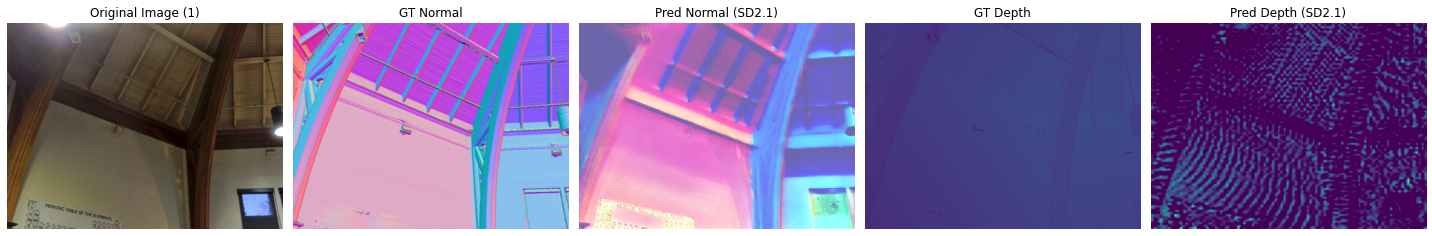


==== Evaluation Metrics (1) ====
Mean Angular Error: 105.6480°
Median Angular Error: 106.6052°
Mean L1 Error: 82.340908
Depth RMSE: 9.894609
Saved visualization to: evaluation_plot2.png


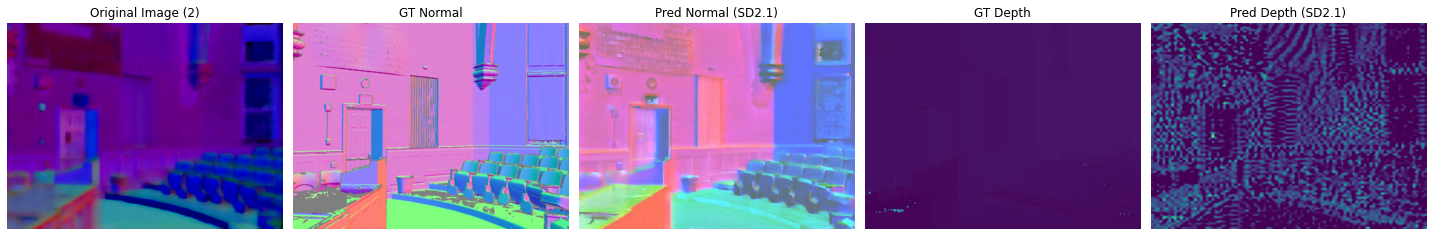


==== Evaluation Metrics (2) ====
Mean Angular Error: 95.6284°
Median Angular Error: 97.8543°
Mean L1 Error: 79.445004
Depth RMSE: 8.819078


In [5]:
# === Paths for Image 1 ===
img_path = "/home/exp1/zihan2/DIODE_dataset/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040.png"
pred_normal_path = "/home/exp1/zihan2/DIODE_dataset/val_normals_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_040.png"
gt_normal_path = "/home/exp1/zihan2/DIODE_dataset/val_normals/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_normal.npy"
pred_depth_path = "/home/exp1/zihan2/DIODE_dataset/val_depths_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_040.npy"
gt_depth_path = "/home/exp1/zihan2/DIODE_dataset/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_040_depth.npy"

# === Paths for Image 2 ===
img_path2 = "/home/exp1/zihan2/DIODE_dataset/val_normals_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_010.png"
pred_normal_path2 = img_path2
gt_normal_path2 = "/home/exp1/zihan2/DIODE_dataset/val_normals/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010_normal.npy"
pred_depth_path2 = "/home/exp1/zihan2/DIODE_dataset/val_depths_predicted_SD1.5/scene_00019_scan_00183_00019_00183_indoors_000_010.npy"
gt_depth_path2 = "/home/exp1/zihan2/DIODE_dataset/val/indoors/scene_00019/scan_00183/00019_00183_indoors_000_010_depth.npy"
pred_depth_path3 = '/home/exp1/zihan2/DIODE_dataset/val_depths_predicted_SD2.1/scene_00019_scan_00183_00019_00183_indoors_000_040.npy'
pred_normal_path3 = '/home/exp1/zihan2/DIODE_dataset/val_normals_predicted_SD2.1/scene_00019_scan_00183_00019_00183_indoors_000_040.png'
pred_depth_path4 = '/home/exp1/zihan2/DIODE_dataset/val_depths_predicted_SD2.1/scene_00019_scan_00183_00019_00183_indoors_000_010.npy'
pred_normal_path4 = '/home/exp1/zihan2/DIODE_dataset/val_normals_predicted_SD2.1/scene_00019_scan_00183_00019_00183_indoors_000_010.png'

def evaluate_and_plot_sd2(
    img_path, pred_normal_path, gt_normal_path, pred_depth_path, gt_depth_path, title_suffix=""
):
    orig_img = np.array(Image.open(img_path))

    pred_normal_img = Image.open(pred_normal_path).convert("RGB")
    pred_normal_np = np.array(pred_normal_img).astype(np.float32) / 255.0

    gt_normal = np.load(gt_normal_path)
    if gt_normal.shape[0] == 3:
        gt_normal_vis = np.transpose(gt_normal, (1, 2, 0))
        gt_normal_tensor = torch.tensor(gt_normal, dtype=torch.float32)
    elif gt_normal.shape[-1] == 3:
        gt_normal_vis = gt_normal
        gt_normal_tensor = torch.tensor(gt_normal, dtype=torch.float32).permute(2, 0, 1)
    elif gt_normal.shape[1] == 3:
        gt_normal_vis = np.transpose(gt_normal, (0, 2, 1))
        gt_normal_tensor = torch.tensor(gt_normal_vis, dtype=torch.float32).permute(2, 0, 1)
    else:
        raise ValueError(f"Unexpected GT normal shape: {gt_normal.shape}")

    gt_normal_vis = (gt_normal_vis + 1) / 2.0
    # Match predicted normal RGB stats to GT normal (for visual similarity)
    gt_mean = gt_normal_vis.mean(axis=(0, 1))
    gt_std = gt_normal_vis.std(axis=(0, 1)) + 1e-6  # avoid div by zero
    pred_mean = pred_normal_np.mean(axis=(0, 1))
    pred_std = pred_normal_np.std(axis=(0, 1)) + 1e-6

    # Scale predicted normal to match GT stats (only for visualization)
    pred_normal_vis = (pred_normal_np - pred_mean) / pred_std * gt_std + gt_mean
    pred_normal_vis = np.clip(pred_normal_vis, 0, 1)
    # Resize pred_normal_vis for display (to match GT normal's spatial size)
    if pred_normal_vis.shape[:2] != gt_normal_vis.shape[:2]:
        pred_normal_vis = np.array(Image.fromarray((pred_normal_vis * 255).astype(np.uint8)).resize(gt_normal_vis.shape[1::-1], Image.BILINEAR)) / 255.0


    # Clamp GT again for safety
    gt_normal_vis = np.clip(gt_normal_vis, 0, 1)


    # Convert predicted normal image to tensor in [-1, 1] range
    pred_normal_tensor = torch.tensor(pred_normal_np * 2 - 1, dtype=torch.float32).permute(2, 0, 1)

    # Resize predicted normal to match GT normal resolution before normalization
    if pred_normal_tensor.shape[-2:] != gt_normal_tensor.shape[-2:]:
        pred_normal_tensor = F.interpolate(pred_normal_tensor.unsqueeze(0), size=gt_normal_tensor.shape[-2:], mode="bilinear", align_corners=False).squeeze(0)

    # Normalize both to unit vectors
    pred_normal_tensor = F.normalize(pred_normal_tensor, dim=0)
    gt_normal_tensor = F.normalize(gt_normal_tensor, dim=0)


    # Resize predicted normal to match GT normal resolution (for fair comparison)
    if pred_normal_tensor.shape[-2:] != gt_normal_tensor.shape[-2:]:
        pred_normal_tensor = F.interpolate(pred_normal_tensor.unsqueeze(0), size=gt_normal_tensor.shape[-2:], mode="bilinear", align_corners=False).squeeze(0)

    cos_sim = F.cosine_similarity(pred_normal_tensor, gt_normal_tensor, dim=0).clamp(-1, 1)
    angles = torch.acos(cos_sim) * (180.0 / np.pi)
    mean_angular_error = angles.mean().item()
    median_angular_error = angles.median().item()
    mean_l1_error = torch.abs(pred_normal_tensor - gt_normal_tensor).mean().item() * 100

    pred_depth = torch.tensor(np.load(pred_depth_path), dtype=torch.float32)
    gt_depth = torch.tensor(np.load(gt_depth_path), dtype=torch.float32)

    if gt_depth.ndim == 3 and gt_depth.shape[-1] == 1:
        gt_depth = gt_depth.squeeze(-1)

    # Resize prediction to GT depth resolution (instead of resizing GT)
    if pred_depth.shape != gt_depth.shape:
        pred_depth = F.interpolate(pred_depth.unsqueeze(0).unsqueeze(0), size=gt_depth.shape[-2:], mode='bilinear', align_corners=False).squeeze()

    # Clamp and normalize for visualization
    eps = 1e-6
    pred_depth = torch.clamp(pred_depth, min=eps)
    gt_depth = torch.clamp(gt_depth, min=eps)

    rmse = torch.sqrt(torch.mean((pred_depth - gt_depth) ** 2)).item()
    pred_depth_vis = normalize(pred_depth).cpu().numpy()
    gt_depth_vis = normalize(gt_depth).cpu().numpy()

    # === Visualization ===
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(orig_img)
    plt.title(f"Original Image {title_suffix}")
    plt.axis("off")

    plt.subplot(1, 5, 2)
    plt.imshow(gt_normal_vis)
    plt.title("GT Normal")
    plt.axis("off")

    plt.subplot(1, 5, 3)
    plt.imshow(pred_normal_vis)
    plt.title("Pred Normal (SD2.1)")
    plt.axis("off")

    plt.subplot(1, 5, 4)
    plt.imshow(gt_depth_vis, cmap="viridis")
    plt.title("GT Depth")
    plt.axis("off")

    plt.subplot(1, 5, 5)
    plt.imshow(pred_depth_vis, cmap="viridis")
    plt.title("Pred Depth (SD2.1)")
    plt.axis("off")

    plt.tight_layout()
    save_path = f"evaluation_plot{title_suffix.replace(' ', '_').replace('(', '').replace(')', '')}.png"
    plt.savefig(save_path, dpi=300)
    print(f"Saved visualization to: {save_path}")
    plt.show()

    # === Metrics ===
    print(f"\n==== Evaluation Metrics {title_suffix} ====")
    print(f"Mean Angular Error: {mean_angular_error:.4f}°")
    print(f"Median Angular Error: {median_angular_error:.4f}°")
    print(f"Mean L1 Error: {mean_l1_error:.6f}")
    print(f"Depth RMSE: {rmse:.6f}")

evaluate_and_plot_sd2(img_path, pred_normal_path3, gt_normal_path, pred_depth_path3, gt_depth_path, title_suffix="(1)")
evaluate_and_plot_sd2(img_path2, pred_normal_path4, gt_normal_path2, pred_depth_path4, gt_depth_path2, title_suffix="(2)")

# Code for generating Albedo/Shading Ground Truths with Intrinsic-Library




In [4]:
import os
from skimage.io import imread, imsave
from intrinsic.pipeline import load_models, run_pipeline
from chrislib.data_util import load_image
from skimage.util import img_as_ubyte
import numpy as np
def intrinsic_decomposition(image, models):
    # Run the intrinsic decomposition pipeline
    results = run_pipeline(models, image)
    # Extract albedo and shading from the results
    albedo = results['hr_alb']
    shading = results['hr_shd']
    return albedo, shading
dataset_root = '/home/exp1/zihan2/DIODE_dataset'
splits = ['train', 'val']
scene_type = 'indoors'  # Adjust if you have 'outdoors' scenes

# Load the pre-trained models
models = load_models('v2')
for split in splits:
    rgb_dir = os.path.join(dataset_root, split, scene_type)
    albedo_dir = os.path.join(dataset_root, f'{split}_albedo', scene_type)
    shading_dir = os.path.join(dataset_root, f'{split}_shading', scene_type)

    for scene_folder in sorted(os.listdir(rgb_dir)):
        scene_path = os.path.join(rgb_dir, scene_folder)
        if not os.path.isdir(scene_path):
            continue

        for scan_folder in sorted(os.listdir(scene_path)):
            scan_path = os.path.join(scene_path, scan_folder)
            if not os.path.isdir(scan_path):
                continue

            # Create corresponding directories for albedo and shading
            os.makedirs(os.path.join(albedo_dir, scene_folder, scan_folder), exist_ok=True)
            os.makedirs(os.path.join(shading_dir, scene_folder, scan_folder), exist_ok=True)

            for file_name in sorted(os.listdir(scan_path)):
                if file_name.endswith(('.png', '.jpg')):
                    image_path = os.path.join(scan_path, file_name)
                    image = load_image(image_path)

                    # Perform intrinsic decomposition
                    albedo, shading = intrinsic_decomposition(image, models)

                    # Save albedo and shading maps
                    base_name = os.path.splitext(file_name)[0]
                    albedo_path = os.path.join(albedo_dir, scene_folder, scan_folder, f'{base_name}_albedo.png')
                    shading_path = os.path.join(shading_dir, scene_folder, scan_folder, f'{base_name}_shading.png')

                    # Ensure values are scaled properly and dtype is uint8
                    albedo = np.squeeze(albedo)
                    shading = np.squeeze(shading)

                    if albedo.dtype in [np.float32, np.float64]:
                        albedo = np.clip(albedo, 0, 1)
                        albedo = img_as_ubyte(albedo)

                    if shading.dtype in [np.float32, np.float64]:
                        shading = np.clip(shading, 0, 1)
                        shading = img_as_ubyte(shading)

                    imsave(albedo_path, albedo)
                    imsave(shading_path, shading)



Using cache found in /home/exp1/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /home/exp1/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master
Using cache found in /home/exp1/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /home/exp1/.cache/torch/hub/facebookresearch_WSL-Images_main
Using cache found in /home/exp1/.cache/torch/hub/facebookresearch_WSL-Images_main
<ipython-input-4-42e3d9244edd>:64: UserWarning: /home/exp1/zihan2/DIODE_dataset/train_albedo/indoors/scene_00000/scan_00000/00000_00000_indoors_060_020_albedo.png is a low contrast image
  imsave(albedo_path, albedo)
<ipython-input-4-42e3d9244edd>:64: UserWarning: /home/exp1/zihan2/DIODE_dataset/train_albedo/indoors/scene_00000/scan_00000/00000_00000_indoors_070_020_albedo.png is a low contrast image
  imsave(albedo_path, albedo)
<ipython-input-4-42e3d9244edd>:64: UserWarning: /home/exp1/zihan2/DIODE_dataset/train_albedo/indoors/scene_00000/scan_00000/00000_00000_indoors_180

OSError: [Errno 28] No space left on device